In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os
import tarfile
from torchvision.datasets.utils import download_url
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from tqdm import tqdm

In [3]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

IMAGE_SIZE = 64
CHANNELS = 3
FLAT_DIM = IMAGE_SIZE * IMAGE_SIZE * CHANNELS
HIDDEN_SIZE = 512
N_BLOCKS = 7
BATCH_SIZE = 3
N_EPOCHS = 100
LEARNING_RATE = 0.0001
BASE_DIST = torch.distributions.Normal(0., 1.)

Using device: cuda


In [4]:
def get_rand_mask_degrees(in_features, hidden_features, out_features, n_layers):
    m = {}
    m['in'] = torch.arange(1, in_features + 1)
    
    m['h'] = []
    for _ in range(n_layers - 1):
        m['h'].append(torch.randint(low=1, high=in_features, size=(hidden_features,)))

    m['out'] = torch.cat([m['in'], m['in']])
    return m

In [5]:
class MaskedLinear(nn.Linear):
    def __init__(self, in_features, out_features, mask_type):
        super().__init__(in_features, out_features)
        self.mask = torch.ones(out_features, in_features, dtype=torch.bool)
        self.mask_type = mask_type

    def forward(self, input):
        self.weight.data.masked_fill_(~self.mask, 0.0)
        return super().forward(input)

In [6]:

class MADE(nn.Module):
    def __init__(self, input_dim, hidden_dim, n_layers=2):
        super().__init__()
        self.input_dim = input_dim
        self.output_dim = 2 * input_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers

        m = get_rand_mask_degrees(input_dim, hidden_dim, self.output_dim, n_layers)
        
        layers = []
        in_d = input_dim
        m_in = m['in']

        for i in range(n_layers):
            is_output_layer = (i == n_layers - 1)

            out_d = self.output_dim if is_output_layer else hidden_dim
            m_out = m['out'] if is_output_layer else m['h'][i]
            
            if is_output_layer:
                m_in = m['h'][-1] 
            elif i > 0:
                m_in = m['h'][i-1] 
            
            layer = MaskedLinear(in_d, out_d, mask_type='h')

            mask = (m_out.unsqueeze(-1) >= m_in.unsqueeze(0)).to(DEVICE)
            layer.mask = mask
            
            layers.append(layer)
            if not is_output_layer:
                layers.append(nn.ReLU())
            
            in_d = hidden_dim


        self.net = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.net(x)


In [7]:
class MAFBlock(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.input_dim = input_dim
        self.st_net = MADE(input_dim, hidden_dim)

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)

        st = self.st_net(x_flat)
        log_s_raw, t = st.chunk(2, dim=1)
        
        log_s = torch.clamp(log_s_raw, min=-5., max=5.) 

        z_flat = x_flat * torch.exp(log_s) + t
        z = z_flat.view(x.size(0), CHANNELS, IMAGE_SIZE, IMAGE_SIZE)

        log_det_j = log_s.sum(dim=1)
        
        return z, log_det_j

    def inverse(self, z):
        z_flat = z.view(z.size(0), -1)
        x_flat = torch.zeros_like(z_flat).to(DEVICE)
        
        for i in tqdm(range(self.input_dim), desc="Inverse (Generating Pixels)"):
            st = self.st_net(x_flat)
            log_s_raw, t = st.chunk(2, dim=1)

            log_s = torch.clamp(log_s_raw, min=-5., max=5.)
            x_flat[:, i] = (z_flat[:, i] - t[:, i]) * torch.exp(-log_s[:, i])

        x = x_flat.view(z.size(0), CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
        return x



In [8]:
class MAF(nn.Module):
    def __init__(self, image_size, channels, hidden_dim, n_blocks):
        super().__init__()
        input_dim = image_size * image_size * channels
        self.n_blocks = n_blocks
        
        self.flows = nn.ModuleList()
        for i in range(n_blocks):
            self.flows.append(MAFBlock(input_dim, hidden_dim))
            self.flows.append(Permute(input_dim))

    def forward(self, x):
        log_det_j_sum = torch.zeros(x.size(0)).to(DEVICE)
        z = x
        for flow in self.flows:
            z, log_det_j = flow(z)
            log_det_j_sum += log_det_j
        
        # log P_X(x) = log P_Z(z) + log|det(J)|
        log_pz = BASE_DIST.log_prob(z.view(z.size(0), -1)).sum(dim=1)
        log_px = log_pz + log_det_j_sum
        
        # Negative Log Likelihood (NLL)
        return -log_px.mean(), z

    def inverse(self, z):
        """تولید تصویر (عکس)"""
        x = z
        for flow in reversed(self.flows):
            x = flow.inverse(x)
        return x
        
    def log_prob(self, x):
        log_det_j_sum = torch.zeros(x.size(0)).to(DEVICE)
        z = x
        for flow in self.flows:
            # Note: The forward call for a flow block returns (z, log_det_j)
            z, log_det_j = flow(z) 
            log_det_j_sum += log_det_j
        
        # log P_Z(z) is the log probability of the base distribution (Gaussian)
        log_pz = BASE_DIST.log_prob(z.view(z.size(0), -1)).sum(dim=1)
        
        # log P_X(x) = log P_Z(z) + log|det(J)|
        log_px = log_pz + log_det_j_sum
        
        return log_px


In [9]:
class Permute(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim
        self.indices = torch.arange(dim - 1, -1, -1).long().to(DEVICE)
        self.inverse_indices = torch.arange(dim).long().to(DEVICE)

    def forward(self, x):
        x_flat = x.view(x.size(0), -1)
        z_flat = x_flat[:, self.indices]
        z = z_flat.view(x.size(0), CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
        return z, torch.zeros(x.size(0)).to(DEVICE)

    def inverse(self, z):
        z_flat = z.view(z.size(0), -1)
        x_flat = z_flat[:, self.inverse_indices]
        x = x_flat.view(z.size(0), CHANNELS, IMAGE_SIZE, IMAGE_SIZE)
        return x



In [10]:

class MVTecADCapsule(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        train_dir = os.path.join(root_dir, 'capsule/train/good')
        for filename in os.listdir(train_dir):
            if filename.endswith(('.png', '.jpg')):
                self.image_paths.append(os.path.join(train_dir, filename))

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

In [11]:
def train_model(model, dataloader, optimizer, epochs):
    print("\nStarting Training...")
    model.train()
    
    for epoch in range(1, epochs + 1):
        epoch_loss = 0
        start_time = torch.cuda.Event(enable_timing=True)
        end_time = torch.cuda.Event(enable_timing=True)
        start_time.record()

        pbar = tqdm(dataloader, desc=f"Epoch {epoch}/{epochs}")
        for x in pbar:
            x = x.to(DEVICE)
            optimizer.zero_grad()
            
            nll_loss, _ = model(x)
            nll_loss.backward()
            optimizer.step()
            
            epoch_loss += nll_loss.item()
            pbar.set_postfix({'NLL Loss': f'{nll_loss.item():.4f}'})

        end_time.record()
        torch.cuda.synchronize()
        train_time_ms = start_time.elapsed_time(end_time)
        avg_loss = epoch_loss / len(dataloader)
        
        print(f"Epoch {epoch} finished. Avg NLL Loss: {avg_loss:.4f} | Time: {train_time_ms / 1000:.2f}s")

    print("Training finished.")
    return train_time_ms / 1000

def generate_images(model, num_samples=5):
    print(f"\nStarting Image Generation (Num Samples: {num_samples})...")
    model.eval()
    z_samples = BASE_DIST.sample([num_samples, CHANNELS, IMAGE_SIZE, IMAGE_SIZE]).to(DEVICE)
    
    start_time = torch.cuda.Event(enable_timing=True)
    end_time = torch.cuda.Event(enable_timing=True)
    start_time.record()
    
    with torch.no_grad():

        x_samples = model.inverse(z_samples)

    end_time.record()
    torch.cuda.synchronize()
    gen_time_ms = start_time.elapsed_time(end_time)
    
    generated_images = (x_samples.cpu().clamp(0, 1).permute(0, 2, 3, 1).numpy() * 255).astype(np.uint8)
    
    print(f"Generation finished. Time for {num_samples} images: {gen_time_ms / 1000:.2f}s")
    
    return generated_images, gen_time_ms / 1000


In [12]:
if __name__ == '__main__':
    data_path = './'

    transform = transforms.Compose([
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), 
        transforms.ToTensor(),
    ])
    
    train_dataset = MVTecADCapsule(root_dir="./", transform=transform)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
    
    print(f"Data ready. Training samples: {len(train_dataset)}")

    model = MAF(IMAGE_SIZE, CHANNELS, HIDDEN_SIZE, N_BLOCKS).to(DEVICE)
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    total_train_time = train_model(model, train_loader, optimizer, N_EPOCHS)
    
    torch.save(model.state_dict(), 'maf_capsule.pth')
    print("\nModel saved to maf_capsule_model.pth")

Data ready. Training samples: 219

Starting Training...


Epoch 1/100: 100%|██████████| 73/73 [00:12<00:00,  5.84it/s, NLL Loss=-19215.9668]


Epoch 1 finished. Avg NLL Loss: -3385.9037 | Time: 12.51s


Epoch 2/100: 100%|██████████| 73/73 [00:12<00:00,  6.02it/s, NLL Loss=-26556.8125]


Epoch 2 finished. Avg NLL Loss: -23758.5350 | Time: 12.13s


Epoch 3/100: 100%|██████████| 73/73 [00:12<00:00,  5.93it/s, NLL Loss=-29190.1465]


Epoch 3 finished. Avg NLL Loss: -24166.1084 | Time: 12.30s


Epoch 4/100: 100%|██████████| 73/73 [00:12<00:00,  6.06it/s, NLL Loss=-32340.1836]


Epoch 4 finished. Avg NLL Loss: -30274.4732 | Time: 12.04s


Epoch 5/100: 100%|██████████| 73/73 [00:12<00:00,  6.08it/s, NLL Loss=-33814.1602]


Epoch 5 finished. Avg NLL Loss: -31759.8931 | Time: 12.01s


Epoch 6/100: 100%|██████████| 73/73 [00:11<00:00,  6.12it/s, NLL Loss=-34857.9805]


Epoch 6 finished. Avg NLL Loss: -32430.4464 | Time: 11.93s


Epoch 7/100: 100%|██████████| 73/73 [00:11<00:00,  6.11it/s, NLL Loss=-33869.0547]


Epoch 7 finished. Avg NLL Loss: -33686.9881 | Time: 11.94s


Epoch 8/100: 100%|██████████| 73/73 [00:11<00:00,  6.13it/s, NLL Loss=-34378.4844]


Epoch 8 finished. Avg NLL Loss: -34022.7375 | Time: 11.90s


Epoch 9/100: 100%|██████████| 73/73 [00:11<00:00,  6.13it/s, NLL Loss=-36418.6172]


Epoch 9 finished. Avg NLL Loss: -34225.0513 | Time: 11.92s


Epoch 10/100: 100%|██████████| 73/73 [00:11<00:00,  6.13it/s, NLL Loss=-36672.4297]


Epoch 10 finished. Avg NLL Loss: -34816.8390 | Time: 11.92s


Epoch 11/100: 100%|██████████| 73/73 [00:11<00:00,  6.11it/s, NLL Loss=-35681.7031]


Epoch 11 finished. Avg NLL Loss: -35441.6966 | Time: 11.94s


Epoch 12/100: 100%|██████████| 73/73 [00:11<00:00,  6.15it/s, NLL Loss=-34316.4961]


Epoch 12 finished. Avg NLL Loss: -35789.4598 | Time: 11.88s


Epoch 13/100: 100%|██████████| 73/73 [00:11<00:00,  6.14it/s, NLL Loss=-37598.6953]


Epoch 13 finished. Avg NLL Loss: -36137.9442 | Time: 11.88s


Epoch 14/100: 100%|██████████| 73/73 [00:11<00:00,  6.15it/s, NLL Loss=-35293.2188]


Epoch 14 finished. Avg NLL Loss: -36516.7971 | Time: 11.86s


Epoch 15/100: 100%|██████████| 73/73 [00:11<00:00,  6.12it/s, NLL Loss=-37118.2969]


Epoch 15 finished. Avg NLL Loss: -36658.8143 | Time: 11.93s


Epoch 16/100: 100%|██████████| 73/73 [00:11<00:00,  6.13it/s, NLL Loss=-36228.0039]


Epoch 16 finished. Avg NLL Loss: -37199.2994 | Time: 11.92s


Epoch 17/100: 100%|██████████| 73/73 [00:11<00:00,  6.12it/s, NLL Loss=-37905.6172]


Epoch 17 finished. Avg NLL Loss: -37329.5447 | Time: 11.92s


Epoch 18/100: 100%|██████████| 73/73 [00:11<00:00,  6.13it/s, NLL Loss=-38207.4727]


Epoch 18 finished. Avg NLL Loss: -37658.2898 | Time: 11.91s


Epoch 19/100: 100%|██████████| 73/73 [00:11<00:00,  6.12it/s, NLL Loss=-38343.5430]


Epoch 19 finished. Avg NLL Loss: -37988.4577 | Time: 11.93s


Epoch 20/100: 100%|██████████| 73/73 [00:11<00:00,  6.10it/s, NLL Loss=-37834.9023]


Epoch 20 finished. Avg NLL Loss: -37259.2746 | Time: 11.97s


Epoch 21/100: 100%|██████████| 73/73 [00:11<00:00,  6.10it/s, NLL Loss=-39214.4570]


Epoch 21 finished. Avg NLL Loss: -37903.4198 | Time: 11.97s


Epoch 22/100: 100%|██████████| 73/73 [00:11<00:00,  6.10it/s, NLL Loss=-36903.0625]


Epoch 22 finished. Avg NLL Loss: -37613.6852 | Time: 11.98s


Epoch 23/100: 100%|██████████| 73/73 [00:11<00:00,  6.12it/s, NLL Loss=-36189.2422]


Epoch 23 finished. Avg NLL Loss: -38049.2791 | Time: 11.93s


Epoch 24/100: 100%|██████████| 73/73 [00:11<00:00,  6.12it/s, NLL Loss=-39954.2344]


Epoch 24 finished. Avg NLL Loss: -38584.6789 | Time: 11.92s


Epoch 25/100: 100%|██████████| 73/73 [00:11<00:00,  6.12it/s, NLL Loss=-37955.5000]


Epoch 25 finished. Avg NLL Loss: -38911.6245 | Time: 11.93s


Epoch 26/100: 100%|██████████| 73/73 [00:11<00:00,  6.11it/s, NLL Loss=-38790.8242]


Epoch 26 finished. Avg NLL Loss: -38715.0278 | Time: 11.95s


Epoch 27/100: 100%|██████████| 73/73 [00:12<00:00,  6.07it/s, NLL Loss=-39222.6953]


Epoch 27 finished. Avg NLL Loss: -39053.8998 | Time: 12.04s


Epoch 28/100: 100%|██████████| 73/73 [00:11<00:00,  6.10it/s, NLL Loss=-37287.9297]


Epoch 28 finished. Avg NLL Loss: -39426.7299 | Time: 11.98s


Epoch 29/100: 100%|██████████| 73/73 [00:11<00:00,  6.11it/s, NLL Loss=-37600.4961]


Epoch 29 finished. Avg NLL Loss: -39299.8455 | Time: 11.95s


Epoch 30/100: 100%|██████████| 73/73 [00:11<00:00,  6.11it/s, NLL Loss=-39489.3438]


Epoch 30 finished. Avg NLL Loss: -39513.5235 | Time: 11.95s


Epoch 31/100: 100%|██████████| 73/73 [00:11<00:00,  6.12it/s, NLL Loss=-37539.6484]


Epoch 31 finished. Avg NLL Loss: -39311.3752 | Time: 11.93s


Epoch 32/100: 100%|██████████| 73/73 [00:11<00:00,  6.12it/s, NLL Loss=-40443.9961]


Epoch 32 finished. Avg NLL Loss: -39685.6047 | Time: 11.93s


Epoch 33/100: 100%|██████████| 73/73 [00:11<00:00,  6.14it/s, NLL Loss=-39599.7969]


Epoch 33 finished. Avg NLL Loss: -39867.3699 | Time: 11.89s


Epoch 34/100: 100%|██████████| 73/73 [00:11<00:00,  6.12it/s, NLL Loss=-40275.0898]


Epoch 34 finished. Avg NLL Loss: -39954.7953 | Time: 11.92s


Epoch 35/100: 100%|██████████| 73/73 [00:12<00:00,  6.08it/s, NLL Loss=-38973.8867]


Epoch 35 finished. Avg NLL Loss: -40057.2908 | Time: 12.01s


Epoch 36/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-40115.7109]


Epoch 36 finished. Avg NLL Loss: -40258.6554 | Time: 11.99s


Epoch 37/100: 100%|██████████| 73/73 [00:11<00:00,  6.11it/s, NLL Loss=-20245.1289]


Epoch 37 finished. Avg NLL Loss: -37852.7482 | Time: 11.96s


Epoch 38/100: 100%|██████████| 73/73 [00:11<00:00,  6.11it/s, NLL Loss=-38651.3359]


Epoch 38 finished. Avg NLL Loss: -34209.1258 | Time: 11.96s


Epoch 39/100: 100%|██████████| 73/73 [00:11<00:00,  6.11it/s, NLL Loss=-37547.2188]


Epoch 39 finished. Avg NLL Loss: -38737.1094 | Time: 11.94s


Epoch 40/100: 100%|██████████| 73/73 [00:12<00:00,  6.08it/s, NLL Loss=-39837.1055]


Epoch 40 finished. Avg NLL Loss: -39820.3843 | Time: 12.01s


Epoch 41/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-41723.5781]


Epoch 41 finished. Avg NLL Loss: -40425.9627 | Time: 11.98s


Epoch 42/100: 100%|██████████| 73/73 [00:12<00:00,  6.08it/s, NLL Loss=-41314.5391]


Epoch 42 finished. Avg NLL Loss: -40443.4952 | Time: 12.02s


Epoch 43/100: 100%|██████████| 73/73 [00:11<00:00,  6.10it/s, NLL Loss=-41468.5625]


Epoch 43 finished. Avg NLL Loss: -40877.1124 | Time: 11.98s


Epoch 44/100: 100%|██████████| 73/73 [00:12<00:00,  6.05it/s, NLL Loss=-42135.0938]


Epoch 44 finished. Avg NLL Loss: -41023.6882 | Time: 12.07s


Epoch 45/100: 100%|██████████| 73/73 [00:11<00:00,  6.10it/s, NLL Loss=-41158.7500]


Epoch 45 finished. Avg NLL Loss: -41103.8747 | Time: 11.98s


Epoch 46/100: 100%|██████████| 73/73 [00:11<00:00,  6.10it/s, NLL Loss=-42099.6680]


Epoch 46 finished. Avg NLL Loss: -39791.3286 | Time: 11.96s


Epoch 47/100: 100%|██████████| 73/73 [00:12<00:00,  6.06it/s, NLL Loss=-42182.7578]


Epoch 47 finished. Avg NLL Loss: -41317.3087 | Time: 12.05s


Epoch 48/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-41388.3086]


Epoch 48 finished. Avg NLL Loss: -41056.3353 | Time: 11.99s


Epoch 49/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-41127.4492]


Epoch 49 finished. Avg NLL Loss: -41498.3394 | Time: 11.99s


Epoch 50/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-40973.6250]


Epoch 50 finished. Avg NLL Loss: -41480.1933 | Time: 11.99s


Epoch 51/100: 100%|██████████| 73/73 [00:11<00:00,  6.11it/s, NLL Loss=-30964.0625]


Epoch 51 finished. Avg NLL Loss: -33482.9491 | Time: 11.94s


Epoch 52/100: 100%|██████████| 73/73 [00:11<00:00,  6.11it/s, NLL Loss=-40177.7656]


Epoch 52 finished. Avg NLL Loss: -37158.2897 | Time: 11.95s


Epoch 53/100: 100%|██████████| 73/73 [00:11<00:00,  6.13it/s, NLL Loss=-39212.6172]


Epoch 53 finished. Avg NLL Loss: -39234.8667 | Time: 11.91s


Epoch 54/100: 100%|██████████| 73/73 [00:11<00:00,  6.14it/s, NLL Loss=-42334.2891]


Epoch 54 finished. Avg NLL Loss: -40541.7717 | Time: 11.89s


Epoch 55/100: 100%|██████████| 73/73 [00:11<00:00,  6.13it/s, NLL Loss=-40554.9531]


Epoch 55 finished. Avg NLL Loss: -39547.9181 | Time: 11.92s


Epoch 56/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-42284.3359]


Epoch 56 finished. Avg NLL Loss: -40961.2711 | Time: 11.99s


Epoch 57/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-42340.9141]


Epoch 57 finished. Avg NLL Loss: -41511.7208 | Time: 11.99s


Epoch 58/100: 100%|██████████| 73/73 [00:11<00:00,  6.10it/s, NLL Loss=-42407.3984]


Epoch 58 finished. Avg NLL Loss: -41799.5069 | Time: 11.97s


Epoch 59/100: 100%|██████████| 73/73 [00:11<00:00,  6.10it/s, NLL Loss=-43384.7188]


Epoch 59 finished. Avg NLL Loss: -41962.2321 | Time: 11.96s


Epoch 60/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-42446.5391]


Epoch 60 finished. Avg NLL Loss: -41707.2058 | Time: 11.99s


Epoch 61/100: 100%|██████████| 73/73 [00:12<00:00,  6.08it/s, NLL Loss=-41521.8281]


Epoch 61 finished. Avg NLL Loss: -42073.7748 | Time: 12.01s


Epoch 62/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-40444.5352]


Epoch 62 finished. Avg NLL Loss: -41929.0756 | Time: 11.98s


Epoch 63/100: 100%|██████████| 73/73 [00:12<00:00,  6.08it/s, NLL Loss=-42613.2500]


Epoch 63 finished. Avg NLL Loss: -42261.0056 | Time: 12.02s


Epoch 64/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-42676.2109]


Epoch 64 finished. Avg NLL Loss: -41968.7193 | Time: 11.99s


Epoch 65/100: 100%|██████████| 73/73 [00:11<00:00,  6.11it/s, NLL Loss=-43032.5469]


Epoch 65 finished. Avg NLL Loss: -42506.9761 | Time: 11.96s


Epoch 66/100: 100%|██████████| 73/73 [00:11<00:00,  6.10it/s, NLL Loss=-40763.9297]


Epoch 66 finished. Avg NLL Loss: -41092.0201 | Time: 11.97s


Epoch 67/100: 100%|██████████| 73/73 [00:12<00:00,  6.07it/s, NLL Loss=-43336.0859]


Epoch 67 finished. Avg NLL Loss: -42477.7758 | Time: 12.03s


Epoch 68/100: 100%|██████████| 73/73 [00:12<00:00,  6.05it/s, NLL Loss=-43750.7773]


Epoch 68 finished. Avg NLL Loss: -42832.1922 | Time: 12.06s


Epoch 69/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-42496.2812]


Epoch 69 finished. Avg NLL Loss: -42536.4587 | Time: 11.99s


Epoch 70/100: 100%|██████████| 73/73 [00:11<00:00,  6.10it/s, NLL Loss=-42808.3633]


Epoch 70 finished. Avg NLL Loss: -42840.9452 | Time: 11.97s


Epoch 71/100: 100%|██████████| 73/73 [00:11<00:00,  6.10it/s, NLL Loss=-42499.2188]


Epoch 71 finished. Avg NLL Loss: -42720.2982 | Time: 11.96s


Epoch 72/100: 100%|██████████| 73/73 [00:12<00:00,  6.06it/s, NLL Loss=-42322.9258]


Epoch 72 finished. Avg NLL Loss: -42781.7964 | Time: 12.05s


Epoch 73/100: 100%|██████████| 73/73 [00:11<00:00,  6.11it/s, NLL Loss=-44087.1797]


Epoch 73 finished. Avg NLL Loss: -43298.5682 | Time: 11.95s


Epoch 74/100: 100%|██████████| 73/73 [00:11<00:00,  6.12it/s, NLL Loss=-42850.1562]


Epoch 74 finished. Avg NLL Loss: -42890.4667 | Time: 11.93s


Epoch 75/100: 100%|██████████| 73/73 [00:11<00:00,  6.10it/s, NLL Loss=-43226.4336]


Epoch 75 finished. Avg NLL Loss: -43048.5455 | Time: 11.97s


Epoch 76/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-43539.4688]


Epoch 76 finished. Avg NLL Loss: -43102.6190 | Time: 12.00s


Epoch 77/100: 100%|██████████| 73/73 [00:11<00:00,  6.10it/s, NLL Loss=-42502.3828]


Epoch 77 finished. Avg NLL Loss: -43168.0135 | Time: 11.96s


Epoch 78/100: 100%|██████████| 73/73 [00:11<00:00,  6.11it/s, NLL Loss=-41435.9453]


Epoch 78 finished. Avg NLL Loss: -42397.7916 | Time: 11.96s


Epoch 79/100: 100%|██████████| 73/73 [00:11<00:00,  6.10it/s, NLL Loss=-42941.9023]


Epoch 79 finished. Avg NLL Loss: -43092.9688 | Time: 11.97s


Epoch 80/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-43197.6484]


Epoch 80 finished. Avg NLL Loss: -43511.0688 | Time: 11.99s


Epoch 81/100: 100%|██████████| 73/73 [00:12<00:00,  6.08it/s, NLL Loss=-44465.8047]


Epoch 81 finished. Avg NLL Loss: -43344.7344 | Time: 12.01s


Epoch 82/100: 100%|██████████| 73/73 [00:12<00:00,  5.96it/s, NLL Loss=-43806.2578]


Epoch 82 finished. Avg NLL Loss: -43319.3579 | Time: 12.24s


Epoch 83/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-43523.3555]


Epoch 83 finished. Avg NLL Loss: -43420.6537 | Time: 11.99s


Epoch 84/100: 100%|██████████| 73/73 [00:12<00:00,  6.02it/s, NLL Loss=-43407.9141]


Epoch 84 finished. Avg NLL Loss: -43680.6510 | Time: 12.13s


Epoch 85/100: 100%|██████████| 73/73 [00:12<00:00,  6.06it/s, NLL Loss=-44212.4688]


Epoch 85 finished. Avg NLL Loss: -43771.8378 | Time: 12.04s


Epoch 86/100: 100%|██████████| 73/73 [00:11<00:00,  6.08it/s, NLL Loss=-42428.3828]


Epoch 86 finished. Avg NLL Loss: -43600.8331 | Time: 12.00s


Epoch 87/100: 100%|██████████| 73/73 [00:12<00:00,  6.08it/s, NLL Loss=-43029.1094]


Epoch 87 finished. Avg NLL Loss: -43737.3266 | Time: 12.01s


Epoch 88/100: 100%|██████████| 73/73 [00:12<00:00,  6.08it/s, NLL Loss=-43947.0859]


Epoch 88 finished. Avg NLL Loss: -43812.6223 | Time: 12.01s


Epoch 89/100: 100%|██████████| 73/73 [00:12<00:00,  6.07it/s, NLL Loss=-44612.4219]


Epoch 89 finished. Avg NLL Loss: -43594.2273 | Time: 12.02s


Epoch 90/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-43103.3555]


Epoch 90 finished. Avg NLL Loss: -43767.6027 | Time: 12.00s


Epoch 91/100: 100%|██████████| 73/73 [00:11<00:00,  6.10it/s, NLL Loss=-29894.8496]


Epoch 91 finished. Avg NLL Loss: -42975.6087 | Time: 11.97s


Epoch 92/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-40168.1328]


Epoch 92 finished. Avg NLL Loss: -40316.3236 | Time: 11.99s


Epoch 93/100: 100%|██████████| 73/73 [00:11<00:00,  6.12it/s, NLL Loss=-43890.3047]


Epoch 93 finished. Avg NLL Loss: -43632.3119 | Time: 11.93s


Epoch 94/100: 100%|██████████| 73/73 [00:11<00:00,  6.12it/s, NLL Loss=-43089.8711]


Epoch 94 finished. Avg NLL Loss: -43816.4080 | Time: 11.93s


Epoch 95/100: 100%|██████████| 73/73 [00:12<00:00,  6.05it/s, NLL Loss=-43896.3242]


Epoch 95 finished. Avg NLL Loss: -43642.7031 | Time: 12.06s


Epoch 96/100: 100%|██████████| 73/73 [00:11<00:00,  6.08it/s, NLL Loss=-43860.8555]


Epoch 96 finished. Avg NLL Loss: -43889.5563 | Time: 12.01s


Epoch 97/100: 100%|██████████| 73/73 [00:12<00:00,  6.08it/s, NLL Loss=-44094.5938]


Epoch 97 finished. Avg NLL Loss: -43970.7307 | Time: 12.00s


Epoch 98/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-42758.4766]


Epoch 98 finished. Avg NLL Loss: -44130.4050 | Time: 11.99s


Epoch 99/100: 100%|██████████| 73/73 [00:11<00:00,  6.09it/s, NLL Loss=-45005.1211]


Epoch 99 finished. Avg NLL Loss: -44412.5040 | Time: 11.99s


Epoch 100/100: 100%|██████████| 73/73 [00:12<00:00,  6.07it/s, NLL Loss=-44221.2500]


Epoch 100 finished. Avg NLL Loss: -44568.5501 | Time: 12.02s
Training finished.

Model saved to maf_capsule_model.pth



Starting Image Generation (Num Samples: 5)...


Inverse (Generating Pixels): 100%|██████████| 12288/12288 [00:20<00:00, 612.84it/s]


Generation finished. Time for 5 images: 140.40s
Total Generation Time (5 images): 140.40 seconds


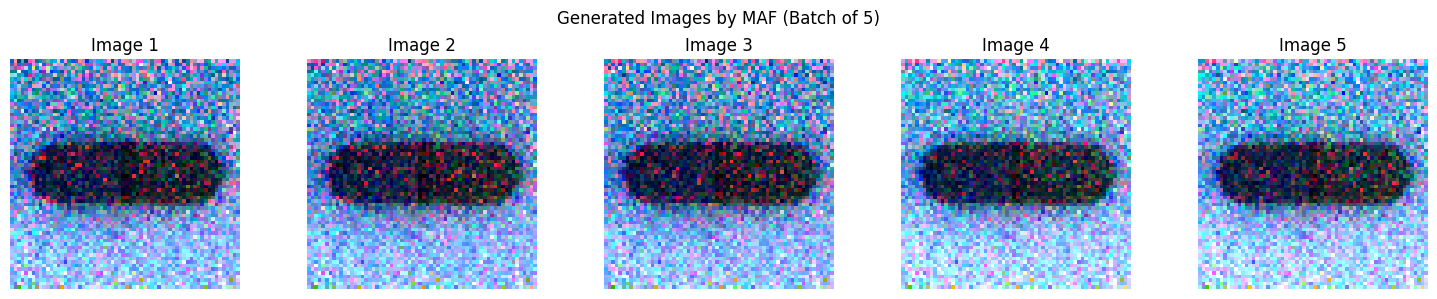

In [13]:
NUM_GEN_SAMPLES = 5
generated_images, total_gen_time = generate_images(model, NUM_GEN_SAMPLES)

print(f"Total Generation Time ({NUM_GEN_SAMPLES} images): {total_gen_time:.2f} seconds")

import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, img in enumerate(generated_images):
    axes[i].imshow(img)
    
    axes[i].set_title(f"Image {i+1}")
    axes[i].axis('off')

plt.suptitle("Generated Images by MAF (Batch of 5)")
plt.tight_layout()
plt.show()

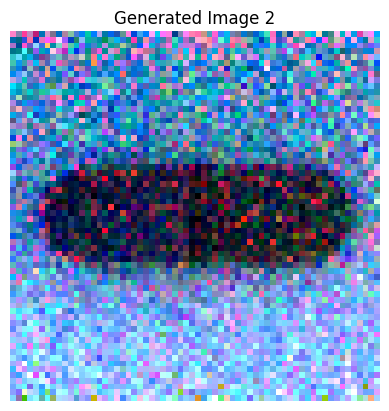

In [14]:
plt.imshow(generated_images[1])
plt.title("Generated Image 2")
plt.axis('off')
plt.show()

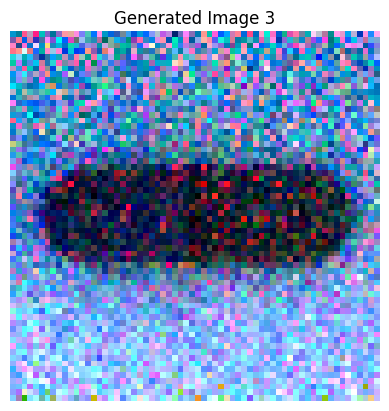

In [15]:
plt.imshow(generated_images[2])
plt.title("Generated Image 3")
plt.axis('off')
plt.show()

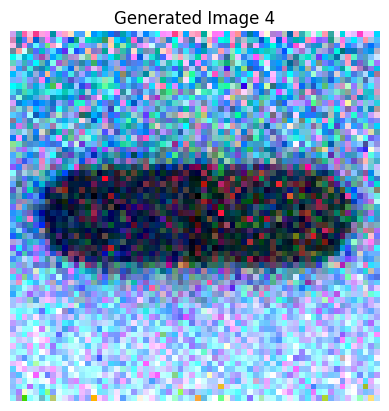

In [16]:
plt.imshow(generated_images[3])
plt.title("Generated Image 4")
plt.axis('off')
plt.show()

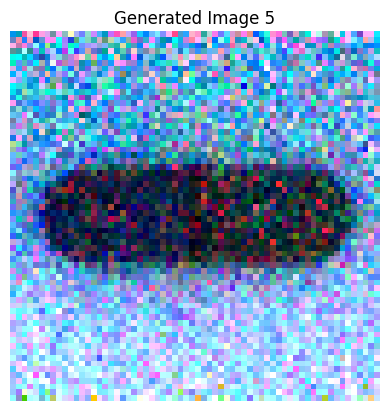

In [17]:
plt.imshow(generated_images[4])
plt.title("Generated Image 5")
plt.axis('off')
plt.show()

In [18]:
def get_anomaly_test_transform():
    def transform_func(image):
        image = image.resize((IMAGE_SIZE, IMAGE_SIZE))
  
        img_np = np.array(image, dtype=np.float32) / 255.0
        # HWC -> CWH
        img_np = img_np.transpose((2, 0, 1))
        tensor = torch.from_numpy(img_np)
        
        return tensor
    return transform_func


class MVTecADAnomalyTestDataset(Dataset):
    """
    بارگذاری تمام تصاویر تست (Normal و Anomaly) از دیتاست MVTecAD Capsule.
    """
    def __init__(self, root_dir, category='capsule', transform=None):
        self.root_dir = root_dir
        self.category = category
        self.transform = transform if transform else get_anomaly_test_transform()
        self.image_paths = []
        self.labels = [] # 0: Normal (Good), 1: Anomaly

        self._load_test_data()

    def _load_test_data(self):
        test_dir = os.path.join(self.root_dir, self.category, 'test')
        if not os.path.exists(test_dir):
            raise FileNotFoundError(f"Test directory not found: {test_dir}")

        for class_name in os.listdir(test_dir):
            class_path = os.path.join(test_dir, class_name)
            if not os.path.isdir(class_path):
                continue
 1
            label = 0 if class_name == 'good' else 1
            for filename in os.listdir(class_path):
                if filename.endswith(('.png', '.jpg')):
                    self.image_paths.append(os.path.join(class_path, filename))
                    self.labels.append(label)

        if not self.image_paths:
            print(f"Warning: No images found in {test_dir}. Check file extensions.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        
        if self.transform:
            image_tensor = self.transform(image)
        else:
            image_tensor = get_anomaly_test_transform()(image) 
            
        label = self.labels[idx]

        return image_tensor, label

In [24]:
from sklearn.metrics import roc_auc_score, precision_recall_curve, auc
def evaluate_anomaly_detection(model, test_loader):
    model.eval()
    all_nlls = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating"):
            images = images.to(DEVICE)

            # Anomaly Score = Negative Log Likelihood (NLL)
            log_prob = model.log_prob(images)
            nll = -log_prob.cpu().numpy()

            all_nlls.extend(nll.tolist())
            all_labels.extend(labels.tolist())


    auroc = roc_auc_score(all_labels, all_nlls)

    precision, recall, _ = precision_recall_curve(all_labels, all_nlls)
    auprc = auc(recall, precision)

    print(f"\nAUROC Score: {auroc:.4f}")
    print(f"AUPRC Score: {auprc:.4f}")

In [25]:
ROOT_DIR = './'

test_dataset = MVTecADAnomalyTestDataset(root_dir=ROOT_DIR, category='capsule')

test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=8, 
    shuffle=False
)

evaluate_anomaly_detection(model, test_loader)

Evaluating: 100%|██████████| 17/17 [00:04<00:00,  3.45it/s]


AUROC Score: 0.7782
AUPRC Score: 0.9422
